# Introduction to nixpy

This is a brief introduction to the nixpy library. 
We will demonstrate how electrophsiology data can be stored in a NIX file and how it can be retrieved and plotted. 
We will use a rather simple example with just a single time-series and a series of neural events.

### Import nix

In [1]:
import datetime
from nixio import *
from utils.plotting import Plotter
from utils.notebook import print_stats, print_metadata_table

%matplotlib inline

### Create and open a File

First we open a new file. The `open` method gets two parameters: the name of the file to open and and a file mode. 
The file mode determines whether the file should be opened for reading or writing.
Choosing the file mode `Overwrite` opens the file for reading and writing and overwrites any existing content.

In [2]:
f = File.open("first_file.demo.h5", FileMode.Overwrite)
print "Format: %s %s" % (f.format, f.version)

Format: nix (1, 0, 0)


### Create a Block element

All other data objects of the NIX data model reside inside a **Block** element. 
A block is used to group data that belongs together.
Each data element in NIX has a property *type* which is used to provide additional semantic meaning.
We will now create a single block and assign a *type* which indicates that the block represents a recording session.

Further we print out the block's *id*. The *id* is unique and automatically generated.

In [3]:
block = f.create_block("Test Session", "nix.session")
print "Name: %s" % block.name
print "Id: %s" % block.id

print_stats(f.blocks)

Name: Test Session
Id: b616fe21-8a37-4f6f-a592-8a652876d935

Blocks                                             (01)
	type: nix.session                          (01)


### Create some testdata

Create some simulated data that we will need in the next example

In [4]:
from utils.lif import lif

model = lif()
times, voltage, spike_times = model.run_const_stim(10000, 0.005)
sampling_interval = times[1] - times[0]

### Write data to the file

From the above generated data we now create to **DataArray** elements. 
The **DataArray** is the central element of the NIX data model.
It represents an n-dimensional array, which also provides a dimension descriptor for each dimension of the data.

In [5]:
# create a data array for the membrane voltage
signal = block.create_data_array("Membrane Voltage", "nix.regular_sampled.time_series", data=voltage)
signal.label = "voltage"
signal.unit  = "V"

# describe the x-axis of the array
xaxis  = signal.append_sampled_dimension(sampling_interval)
xaxis.label = "time"
xaxis.unit  = "s"

# create a data array for the spiketimes
spikes = block.create_data_array("Spike Times", "nix.events.spike_times", data=spike_times)
spikes.label = "time"
spikes.unit  = "s"
spikes.append_set_dimension()

print_stats(block.data_arrays)


DataArrays                                         (02)
	type: nix.regular_sampled.time_series      (01)
	type: nix.events.spike_times               (01)


### Create a tag

The signal and the spike train are stored such that all important information like units,
labels and sampling interval etc. can be interpreted correctly.

However, one information is still missing: we would like to indicate that the spike train
was derived from the time series and that the spike times correspond to the time-serie's x-axis.
In NIX this can be achieved using a **MultiTag**. 
This tag can be used to define points of interest (e.g. spike times) inside other data (e.g. time-series).

In the next step we create a tag in order to indicate that the times in `spikes` occured in the recorded signal

In [6]:
spike_tag = block.create_multi_tag("Spike Times", "nix.events.spike_times", spikes)
spike_tag.references.append(signal)

print_stats(block.multi_tags)


MultiTags                                          (01)
	type: nix.events.spike_times               (01)


### Define date sources

Provenance of certain data elements in the the file can be indecated via soures:

In [7]:
source = block.create_source("Electrode 01", "nix.electrode")
signal.sources.append(source)

print_stats(signal.sources)


Sources                                            (01)
	type: nix.electrode                        (01)


### Plot the result

Since the NIX data model fully describes the stored data semantically, it is possible to implement a generic
plotting tool, that uses this information to generate a nice visualization of the data.


Blocks                                             (01)
	type: nix.session                          (01)

DataArrays                                         (02)
	type: nix.regular_sampled.time_series      (01)
	type: nix.events.spike_times               (01)

MultiTags                                          (01)
	type: nix.events.spike_times               (01)

Sources                                            (01)
	type: nix.electrode                        (01)


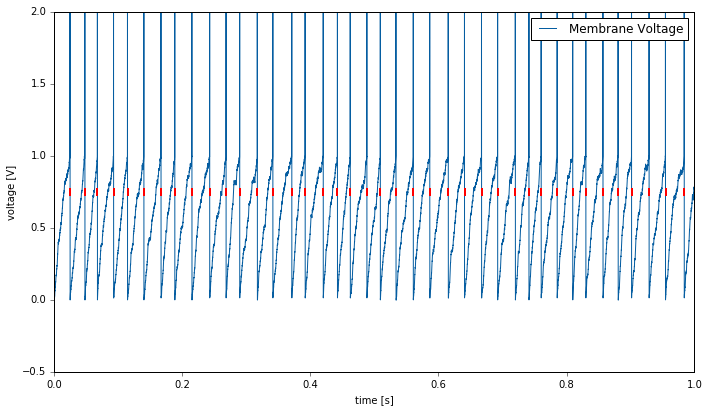

In [8]:
plotter = Plotter(width=1000, height=500)
plotter.add(spikes, color="red")
plotter.add(signal)

plotter.plot()

print_stats(f.blocks)
print_stats(f.blocks[0].data_arrays)
print_stats(f.blocks[0].multi_tags)
print_stats(f.blocks[0].sources)

### Adding some metadata to the file

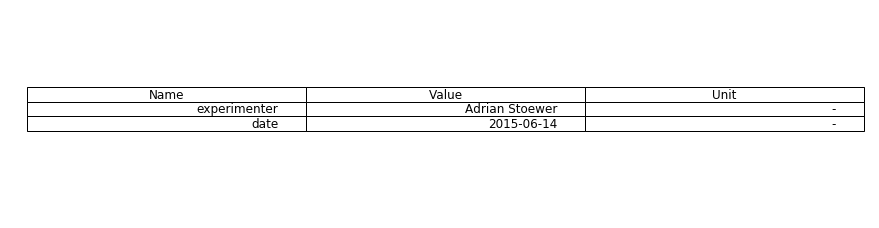

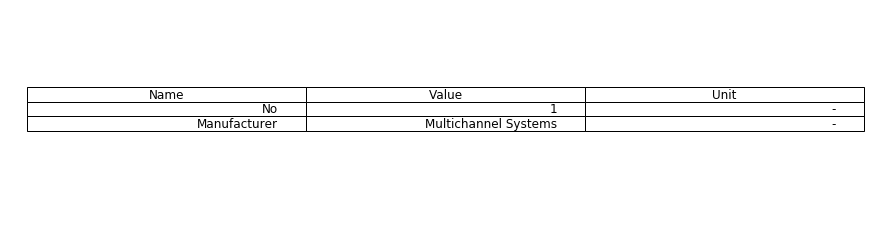

In [9]:
session = f.create_section("Test Session", "nix.session")
session["experimenter"] = "Adrian Stoewer"
session["date"] = "2015-06-14"

electrode = session.create_section("Electrode 01", "nix.electrode")
electrode["No"] = 1
electrode["Manufacturer"] = "Multichannel Systems"

t = print_metadata_table(session)
t = print_metadata_table(electrode)

In [10]:
block.metadata = session
source.metadata = electrode

print(block.metadata["experimenter"])

Adrian Stoewer


In [11]:
f.close()